In [176]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder


fifa = pd.read_csv('../data/raw/FIFA_players_21.csv')


In [177]:
fifa = fifa.drop(columns=['defending_marking','loaned_from','real_face','nation_jersey_number','nation_position','player_tags','player_traits','joined','player_url','long_name','body_type','work_rate'])
print(fifa.columns.tolist())

['sofifa_id', 'short_name', 'age', 'dob', 'height_cm', 'weight_kg', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'release_clause_eur', 'team_position', 'team_jersey_number', 'contract_valid_until', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_posi

In [178]:
fifa['release_clause_eur'] = np.where(fifa['release_clause_eur'].isnull,fifa['value_eur']*1.8,fifa['release_clause_eur']) 
fifa['release_clause_eur'].head(180)
fifa['release_clause_eur']=np.log1p(fifa['release_clause_eur']).round(5)
fifa['release_clause_eur'].tail()


18939    11.18444
18940    11.05091
18941    11.05091
18942    11.18444
18943    10.89676
Name: release_clause_eur, dtype: float64

In [179]:
fifa['value_eur'] = np.log1p(fifa['value_eur']).round(5)
fifa=fifa[fifa['value_eur'] != 0]
fifa['value_eur'].head(900)

0      18.02764
1      17.64415
2      18.13300
3      18.19754
4      18.31532
         ...   
916    16.38046
917    16.25786
918    16.34124
919    16.34124
920    16.25786
Name: value_eur, Length: 900, dtype: float64

In [180]:
fifa['dob'] = pd.to_datetime(fifa['dob'], format='%m/%d/%Y', errors='coerce')

In [181]:
encoder=TargetEncoder(cols=['club_name'],smoothing=0.3)
fifa['club_name']=encoder.fit_transform(fifa[['club_name']],fifa['overall'])

In [182]:
encoder=TargetEncoder(cols=['nationality'],smoothing=0.3)
fifa['nationality']=encoder.fit_transform(fifa[['nationality']],fifa['overall'])

In [183]:
encoder=TargetEncoder(cols=['league_name'],smoothing=0.3)
fifa['league_name']=encoder.fit_transform(fifa[['league_name']],fifa['overall'])

In [184]:
fifa['player_position_copy'] = fifa['player_positions'].copy()

encoder = TargetEncoder(cols=['player_position_copy'], smoothing=0.3)
fifa['player_position_encoded'] = encoder.fit_transform(fifa[['player_position_copy']], fifa['overall'])
fifa.drop(columns=['player_position_copy'],inplace=True)


In [185]:
fifa['player_position_encoded'].head()

0    65.634522
1    65.953488
2    64.506576
3    64.909770
4    65.638799
Name: player_position_encoded, dtype: float64

In [186]:
fifa['player_positions'].head()

0    RW, ST, CF
1        ST, LW
2            GK
3            ST
4       LW, CAM
Name: player_positions, dtype: object

In [187]:
# One-hot encoding
 
def categorize_position(pos):
    attackers = ['ST', 'CF', 'LW', 'RW', 'LF', 'RF']
    midfielders = ['CM', 'CAM', 'CDM', 'LM', 'RM', 'LWM', 'RWM']
    defenders = ['CB', 'LB', 'RB', 'LWB', 'RWB']
    if pos == 'GK':
        return 'GK'
    elif pos in attackers:
        return 'Attacker'
    elif pos in midfielders:
        return 'Midfielder'
    elif pos in defenders:
        return 'Defender'
    else:
        return 'Other'

fifa['pos_group'] = fifa['team_position'].apply(categorize_position)

fifa['is_goalkeeper'] = (fifa['pos_group'] == 'GK').astype(int)

pos_dummies = pd.get_dummies(fifa['pos_group'])
pos_dummies = pos_dummies.drop(columns=['GK', 'Other'], errors='ignore')

fifa = pd.concat([fifa, pos_dummies], axis=1)






In [188]:
fifa['is_right_foot'] = fifa['preferred_foot'].str.lower().apply(lambda x: 1 if 'right' in x else 0)
fifa['is_left_foot'] = fifa['preferred_foot'].str.lower().apply(lambda x: 1 if 'left' in x else 0)
# fifa.drop( columns=['preferred_foot'] , inplace=True)


In [189]:
fifa_GK=fifa[fifa['player_positions'] == 'GK'].copy()
fifa_OUT=fifa[fifa['player_positions'] != 'GK'].copy()

fifa_GK=fifa_GK.drop(columns=['pace','shooting','passing','dribbling','defending','physic','team_position', 'pos_group','Attacker','Defender','Midfielder','preferred_foot','player_positions'],axis=1)
fifa_OUT=fifa_OUT.drop(columns=['gk_diving','gk_handling','gk_kicking','gk_reflexes','gk_speed','gk_positioning','team_position', 'pos_group','is_goalkeeper','preferred_foot','player_positions'],axis=1)


fifa_GK[['league_name','club_name','nationality']]=np.log1p(fifa_GK[['league_name','club_name','nationality']]).round(5)
fifa_OUT[['league_name','club_name','nationality']]=np.log1p(fifa_OUT[['league_name','club_name','nationality']]).round(5)


In [190]:
types_summary=pd.DataFrame({
    "Colana" : fifa.columns,
    "Types" : fifa.dtypes.values,
    "Nr_unique_values": fifa.nunique().values,
    'Missing_values':fifa.isnull().sum()
})


gk_types_summary=pd.DataFrame({
    "Colana" : fifa_GK.columns,
    "Types" : fifa_GK.dtypes.values,
    "Nr_unique_values": fifa_GK.nunique().values,
    'Missing_values':fifa_GK.isnull().sum()
})


out_types_summary=pd.DataFrame({
    "Colana" : fifa_OUT.columns,
    "Types" : fifa_OUT.dtypes.values,
    "Nr_unique_values": fifa_OUT.nunique().values,
    'Missing_values':fifa_OUT.isnull().sum()
})

print(types_summary)
print(gk_types_summary)
print(out_types_summary)

types_summary.to_csv("C:/Users/Lukas/Desktop/CVT_Data_Set/fifa_summary.csv", index=False)
gk_types_summary.to_csv("C:/Users/Lukas/Desktop/CVT_Data_Set/fifa_GK_summary.csv", index=False)
out_types_summary.to_csv("C:/Users/Lukas/Desktop/CVT_Data_Set/fifa_OUT_summary.csv", index=False)
fifa_OUT.to_csv("C:/Users/Lukas/Desktop/CVT_Data_Set/Out_summary.csv", index=False)
fifa_GK.to_csv("C:/Users/Lukas/Desktop/CVT_Data_Set/GK_summary.csv", index=False)

                      Colana           Types  Nr_unique_values  Missing_values
sofifa_id          sofifa_id           int64             18707               0
short_name        short_name          object             17664               0
age                      age           int64                28               0
dob                      dob  datetime64[ns]              6197               0
height_cm          height_cm           int64                50               0
...                      ...             ...               ...             ...
Attacker            Attacker            bool                 2               0
Defender            Defender            bool                 2               0
Midfielder        Midfielder            bool                 2               0
is_right_foot  is_right_foot           int64                 2               0
is_left_foot    is_left_foot           int64                 2               0

[102 rows x 4 columns]
                            

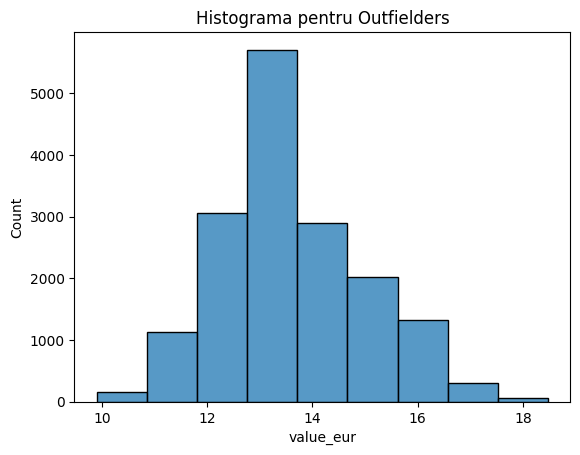

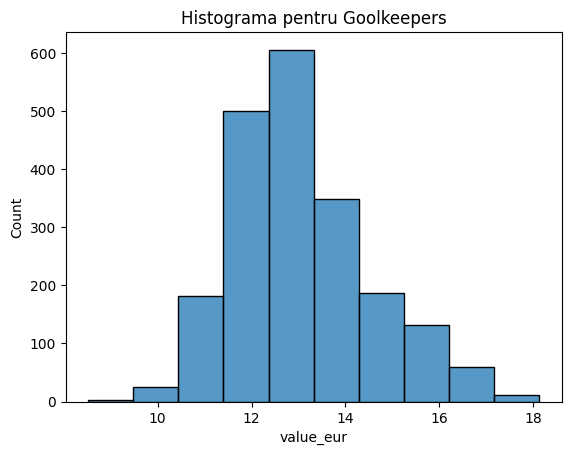

In [191]:
sns.histplot(data=fifa_OUT ,x='value_eur',binwidth=1)
plt.title("Histograma pentru Outfielders")
plt.show()
sns.histplot(data=fifa_GK ,x='value_eur',binwidth=1,)
plt.title("Histograma pentru Goolkeepers")
plt.show()

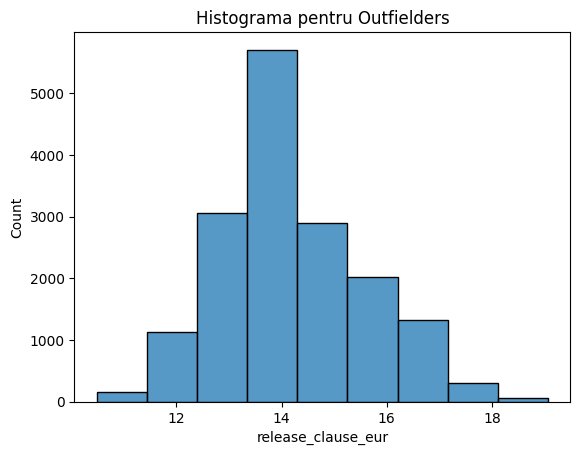

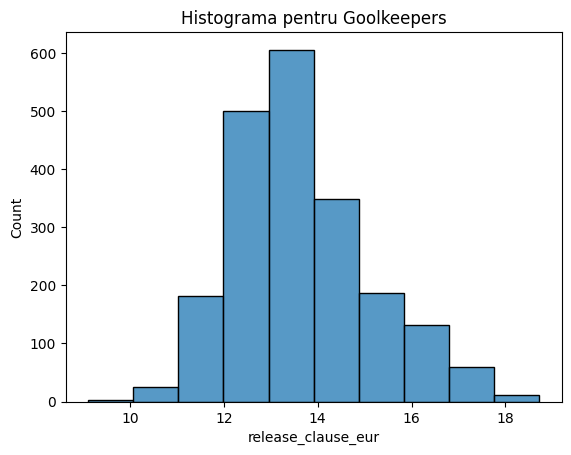

In [192]:
sns.histplot(data=fifa_OUT ,x='release_clause_eur',binwidth=1)
plt.title("Histograma pentru Outfielders")
plt.show()
sns.histplot(data=fifa_GK ,x='release_clause_eur',binwidth=1)
plt.title("Histograma pentru Goolkeepers")
plt.show()

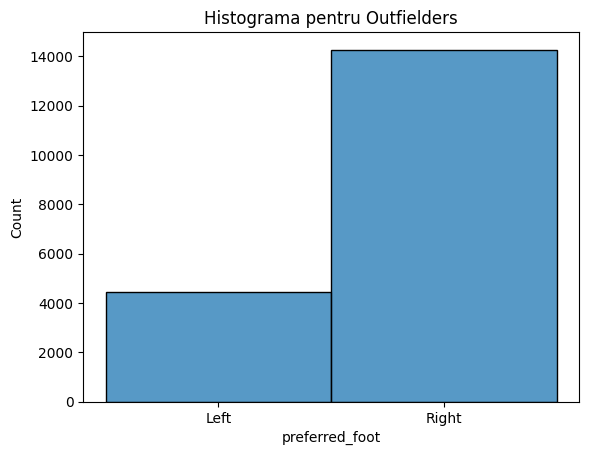

In [193]:
sns.histplot(data=fifa ,x='preferred_foot',binwidth=1)
plt.title("Histograma pentru Outfielders")
plt.show()

In [ ]:
all_positions = fifa['player_positions'].str.split(', ').explode()


sns.histplot(all_positions, discrete=True)
plt.title("Histograma de pozitii")
plt.show()


KeyError: 'player_positions'